In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.1 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd

In [ ]:
data=pd.read_csv('diabetes.csv')
data.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [ ]:
data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [ ]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

some of the values in the dataset attributes are labeled as zero like the value of glucose and blood pressure can't be zero we need to find and tackle those zeros with mean imputation

In [ ]:
print("No. of Zero Values in Glucose ", data[data['Glucose']==0].shape[0])
print("No. of Zero Values in Blood Pressure ", data[data['BloodPressure']==0].shape[0])
print("No. of Zero Values in SkinThickness ", data[data['SkinThickness']==0].shape[0])
print("No. of Zero Values in Insulin ", data[data['Insulin']==0].shape[0])
print("No. of Zero Values in BMI ", data[data['BMI']==0].shape[0])

No. of Zero Values in Glucose  5
No. of Zero Values in Blood Pressure  35
No. of Zero Values in SkinThickness  227
No. of Zero Values in Insulin  374
No. of Zero Values in BMI  11


At the same time there is also an class
imbalance


In [ ]:
N, P = data['Outcome'].value_counts()
print('Negative (0):', N)
print('Positive (1):', P)

Negative (0): 500
Positive (1): 268


Class Distribution

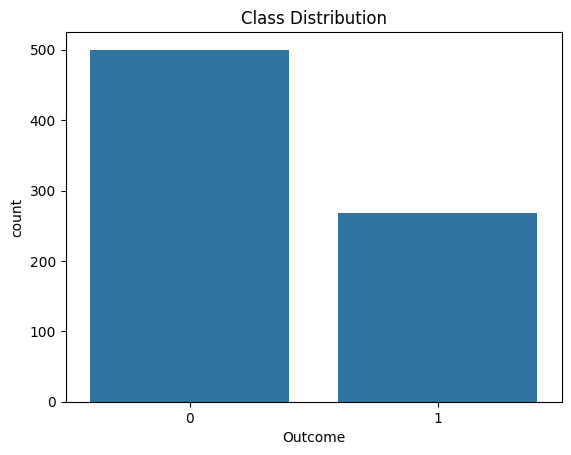

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=data, x='Outcome')
plt.title("Class Distribution")
plt.show()

Pair Plot with KDE and Correlation Values

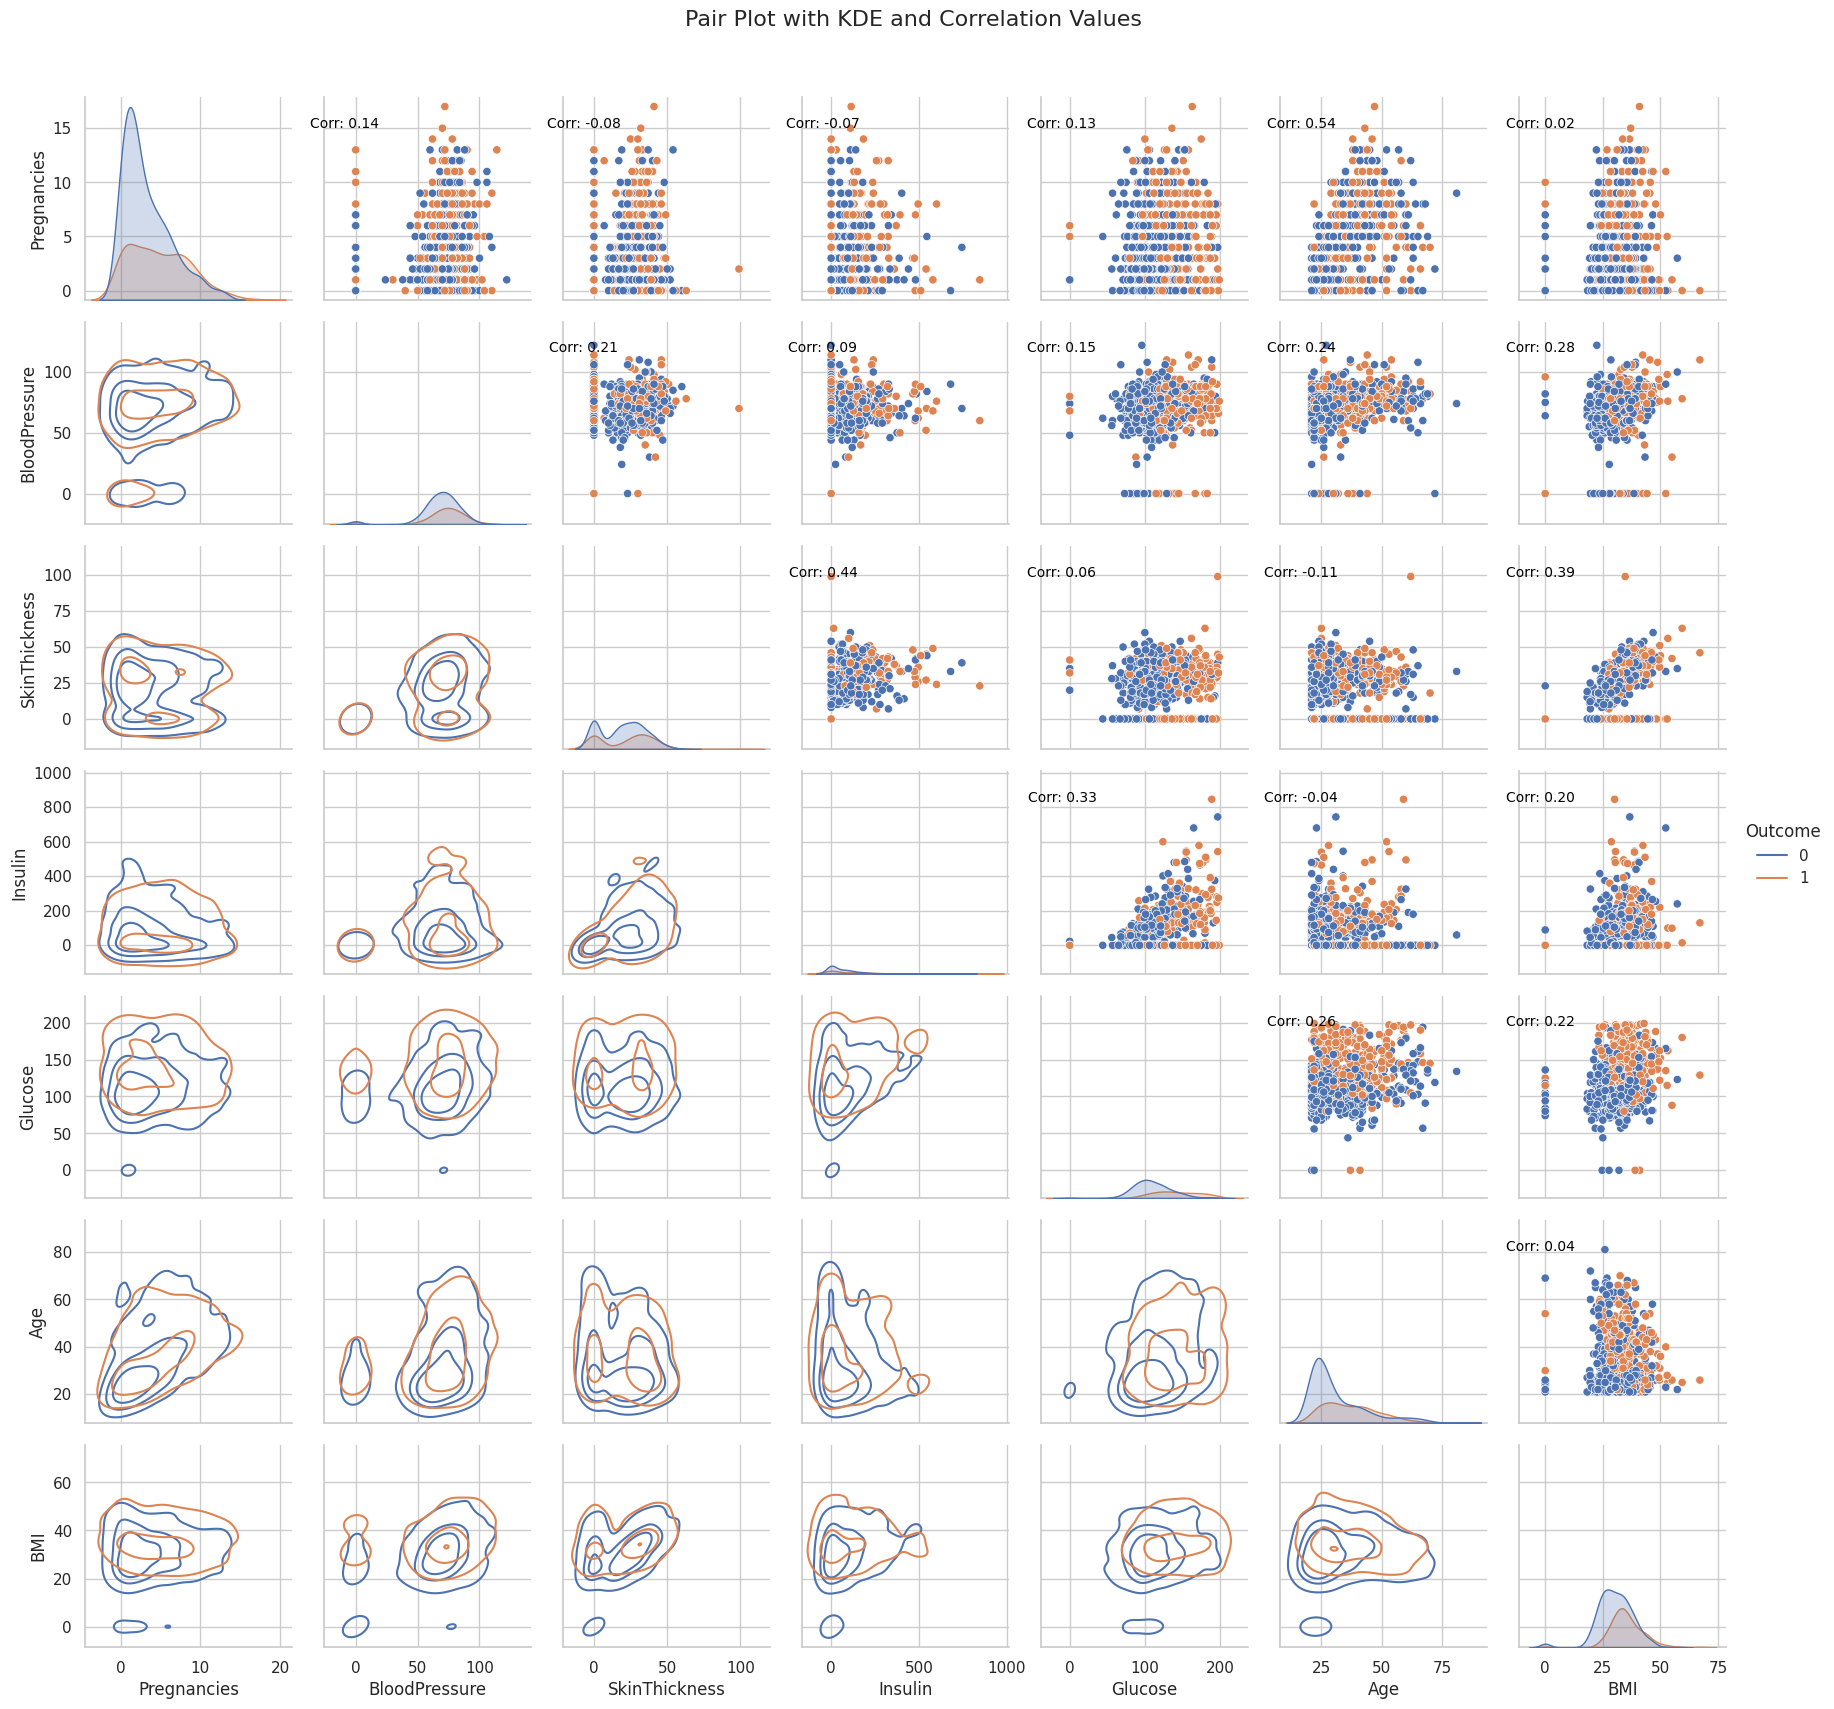

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


selected_features = data[['Pregnancies','BloodPressure', 'SkinThickness', 'Insulin', 'Glucose', 'Age', 'BMI', 'Outcome']]


sns.set(style="whitegrid")
g = sns.PairGrid(selected_features, hue='Outcome')
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, shade=True)
g.map_lower(sns.kdeplot, levels=4, cmap="Blues_d")
g.add_legend()


corr_matrix = selected_features.corr()
for i, j in zip(*plt.np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].annotate(f'Corr: {corr_matrix.iloc[i, j]:.2f}', (0.1, 0.85), xycoords='axes fraction', ha='center', fontsize=10, color='black')


g.fig.subplots_adjust(top=0.93)
g.fig.suptitle("Pair Plot with KDE and Correlation Values", fontsize=16)

plt.show()


Box Plots for Outlier Detection

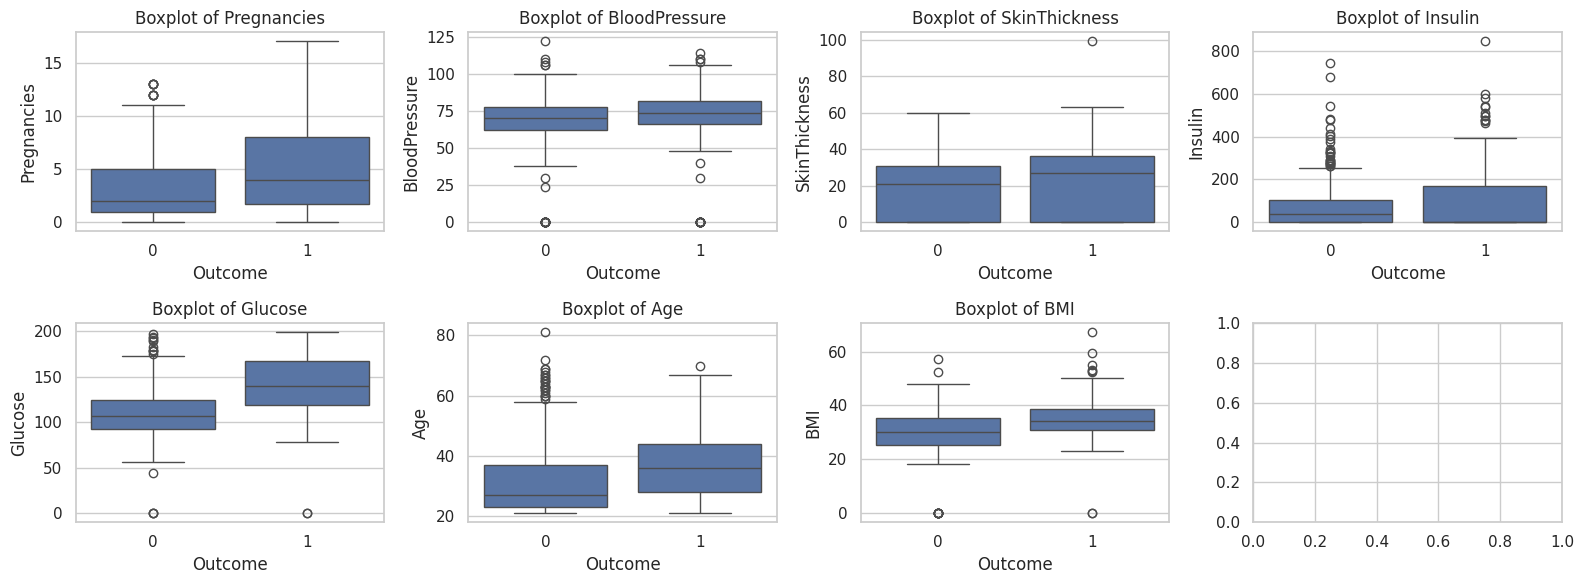

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_features = data[['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'Glucose', 'Age', 'BMI', 'Outcome']]

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
for i, feature in enumerate(selected_features.columns[:-1]):
    sns.boxplot(x='Outcome', y=feature, data=selected_features, ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()


Tackle the zero values in the attributes may be lead to majority classbias                     Assumptions:

Binary classification problem with two classes: Majority class (label 0) and Minority class (label 1).
The dataset is imbalanced, with the number of instances in the majority class (M) being twice the number of instances in the minority class (m), i.e., M = 2m.
Mean imputation is performed by replacing missing (zero) values with the mean (μ) of the entire dataset.
Proof:
Let P(class=1) represent the probability of an instance belonging to the minority class (label 1) before mean imputation.

Initial minority class distribution:
P(class=1) = m / (m + M)

After mean imputation, all instances in the dataset are assigned the same mean value μ. Therefore, the new class distribution for the minority class becomes:

New minority class distribution:
P(class=1) = (m + M) / (m + M)

Since M = 2m (due to the class imbalance), we can substitute:

P(class=1) = (m + 2m) / (m + 2m)

P(class=1) = 3m / (3m)

Now, we can simplify:

P(class=1) = 1

The final result demonstrates that after mean imputation, the new distribution for the minority class becomes 1, meaning that all instances in the minority class are classified as the minority class. This is a clear illustration of how mean imputation introduces a significant bias in favor of the majority class, as it results in all instances in the minority class being assigned the same value and, therefore, all being classified as the minority class.

So it is important to fill the minority class instances with only minority class data and majority class instances with majority class data

Class Aware Mean Imputation

In [ ]:
data[['BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = data.groupby('Outcome')[['BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].transform(lambda x: x.replace(0, x.mean()))

Importing Necessary Libraries

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from scipy import stats
from scipy.stats import uniform, randint
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

Method for Inter-Quartile Outlier Rejection

In [ ]:
def Manual(data, numeric_columns=None, outlier_factor=1.5, keep_outliers=False):
    data_copy = data.copy()

    if numeric_columns is None:
        numeric_columns = data_copy.select_dtypes(include=['number']).columns

    for col in numeric_columns:
        Q1 = data_copy[col].quantile(0.25)
        Q3 = data_copy[col].quantile(0.75)
        IQR = Q3 - Q1


        lower_bound = Q1 - outlier_factor * IQR
        upper_bound = Q3 + outlier_factor * IQR

        if keep_outliers:
            data_copy = data_copy[(data_copy[col] < lower_bound) | (data_copy[col] > upper_bound)]
        else:
            data_copy = data_copy[(data_copy[col] >= lower_bound) & (data_copy[col] <= upper_bound)]

    return data_copy


Feature Selection

In [ ]:
data = Manual(data)
data = data.reset_index(drop=True)

Y_Lavel = data.iloc[:, -1]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_Data = data.drop(['Outcome'],axis=1).values
X_Data = sc.fit_transform(X_Data)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_Data, Y_Lavel)
selected_features_indices = selector.get_support(indices=True)
print(selected_features_indices)
X_Data = selector.transform(X_Data)

[0 1 2 3 4 5 6 7]


In [ ]:
X_Data

array([[ 0.70238618,  1.12751837,  0.04172539, ...,  0.32598622,
         0.89644422,  1.70750383],
       [-0.85455306, -1.14103623, -0.51618074, ..., -0.80782372,
        -0.26557803, -0.10283567],
       [ 1.32516187,  2.38782648, -0.70214945, ..., -1.34233413,
         1.08590437, -0.00755464],
       ...,
       [ 0.39099833,  0.15528068,  0.04172539, ..., -0.87261286,
        -0.71186194, -0.1981167 ],
       [-0.85455306,  0.3353247 , -1.07408688, ..., -0.24091875,
        -0.27399848,  1.42166075],
       [-0.85455306, -0.85296581, -0.14424332, ..., -0.1923269 ,
        -0.41714615, -0.86508388]])

Random OverSampler for Class Imbalance Problem

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=69)
X_Data, Y_Lavel = ros.fit_resample(X_Data, Y_Lavel)

n_splits = 30
kf = KFold(n_splits=n_splits, shuffle=True, random_state=69)

Method for Evaluation Metrics

In [ ]:
def metrics(y_true, y_pred, probas_):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    roc_auc = roc_auc_score(y_true, probas_[:, 1])

    fpr, tpr, _ = roc_curve(y_true, probas_[:, 1])

    return tn, fp, fn, tp, roc_auc, fpr, tpr

FOR STORING ACCURACY WE ARE CREATING A LIST

In [ ]:
results = []

K NEAREST NEIGBOUR

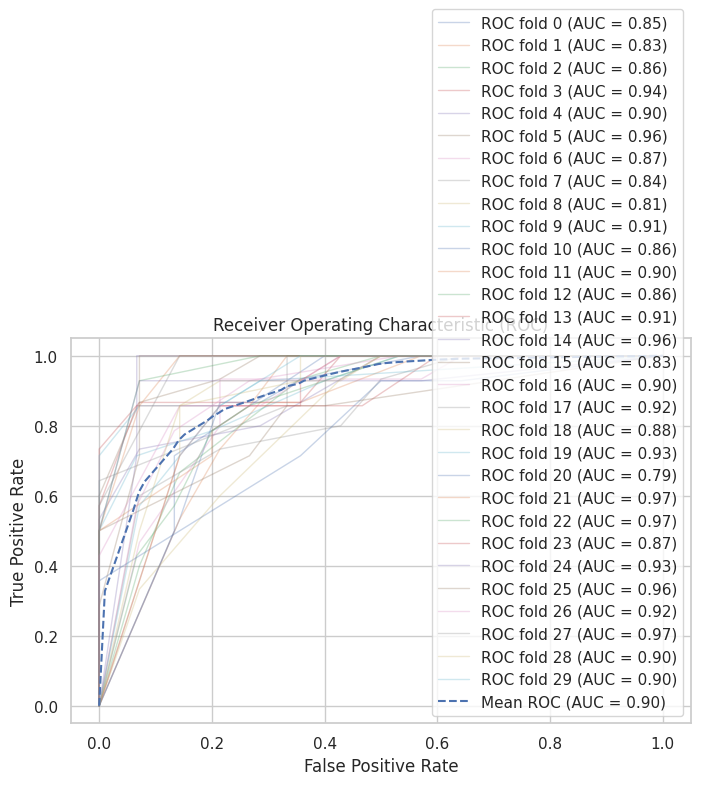

Accuracy (Avg. +/- Std.) is 0.810 +/- 0.069
Sensitivity (Avg. +/- Std.) is 0.891 +/- 0.085
Specificity (Avg. +/- Std.) is 0.729 +/- 0.092
Precision (Avg. +/- Std.) is 0.770 +/- 0.067
FOR (Avg. +/- Std.) is 0.125 +/- 0.089
DOR (Avg. +/- Std.) is inf +/- nan


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_knn = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]


    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_Train, Y_Train)

    y_pred_proba = knn.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_knn.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)


    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))


    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "KNN",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

SUPPORT VECTOR MACHINE

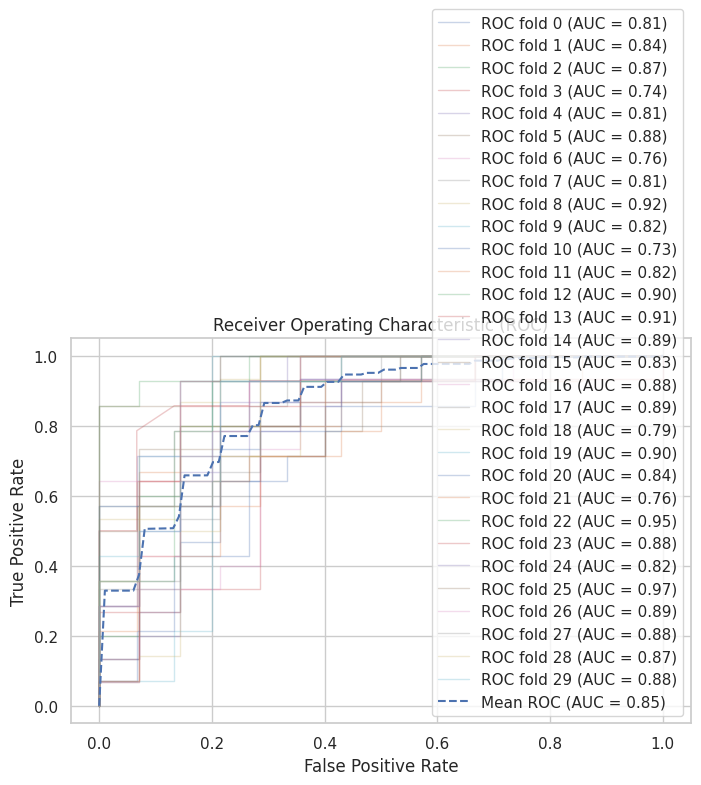

Accuracy (Avg. +/- Std.) is 0.769 +/- 0.067
Sensitivity (Avg. +/- Std.) is 0.762 +/- 0.113
Specificity (Avg. +/- Std.) is 0.776 +/- 0.091
Precision (Avg. +/- Std.) is 0.777 +/- 0.072
FOR (Avg. +/- Std.) is 0.225 +/- 0.093
DOR (Avg. +/- Std.) is inf +/- nan


In [ ]:
from sklearn.svm import SVC

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_svm = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]


    svm = SVC(probability=True, kernel='linear')
    svm.fit(X_Train, Y_Train)

    y_pred_proba = svm.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_svm.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)


    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))


    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "SUPPORT VECTOR MACHINE",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

NAVIES BAYES

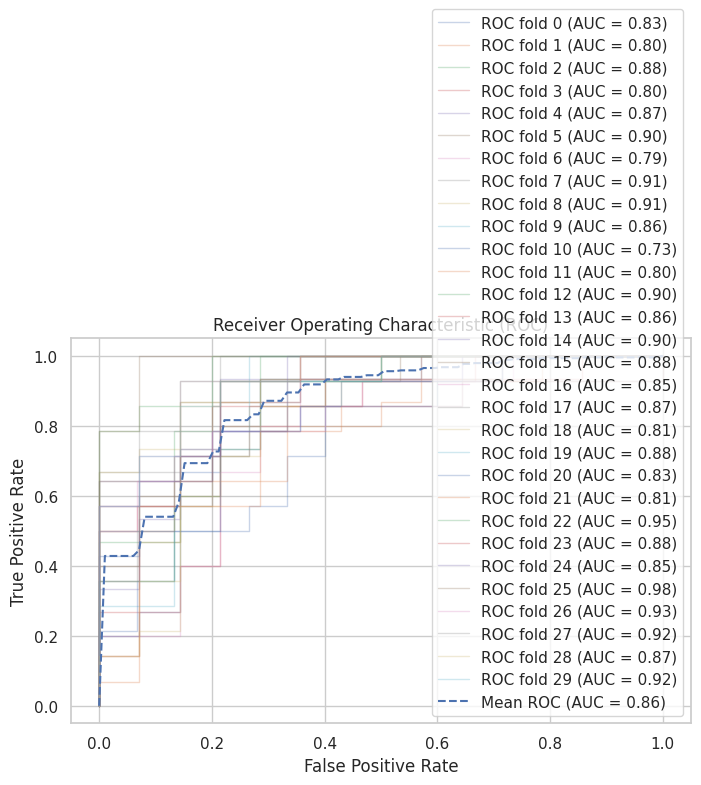

Accuracy (Avg. +/- Std.) is 0.778 +/- 0.057
Sensitivity (Avg. +/- Std.) is 0.778 +/- 0.112
Specificity (Avg. +/- Std.) is 0.776 +/- 0.074
Precision (Avg. +/- Std.) is 0.779 +/- 0.057
FOR (Avg. +/- Std.) is 0.211 +/- 0.090
DOR (Avg. +/- Std.) is inf +/- nan


In [ ]:
from sklearn.naive_bayes import GaussianNB

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_nb = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]


    nb = GaussianNB()
    nb.fit(X_Train, Y_Train)

    y_pred_proba = nb.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_nb.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)


    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))


    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "NAVIES BAYES",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity":np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

RANDOM FOREST

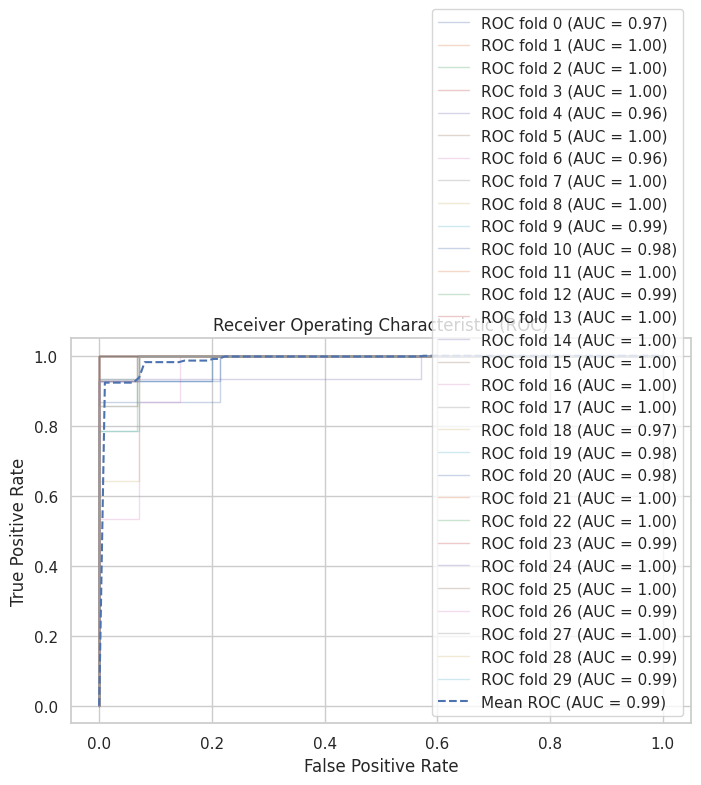

Accuracy (Avg. +/- Std.) is 0.953 +/- 0.041
Sensitivity (Avg. +/- Std.) is 0.986 +/- 0.028
Specificity (Avg. +/- Std.) is 0.921 +/- 0.078
Precision (Avg. +/- Std.) is 0.930 +/- 0.066
FOR (Avg. +/- Std.) is 0.014 +/- 0.029
DOR (Avg. +/- Std.) is inf +/- nan


In [ ]:
from sklearn.ensemble import RandomForestClassifier

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_rf = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=69)

    rf.fit(X_Train, Y_Train)

    y_pred_proba = rf.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_rf.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "RANDOM FOREST",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

ADABoost

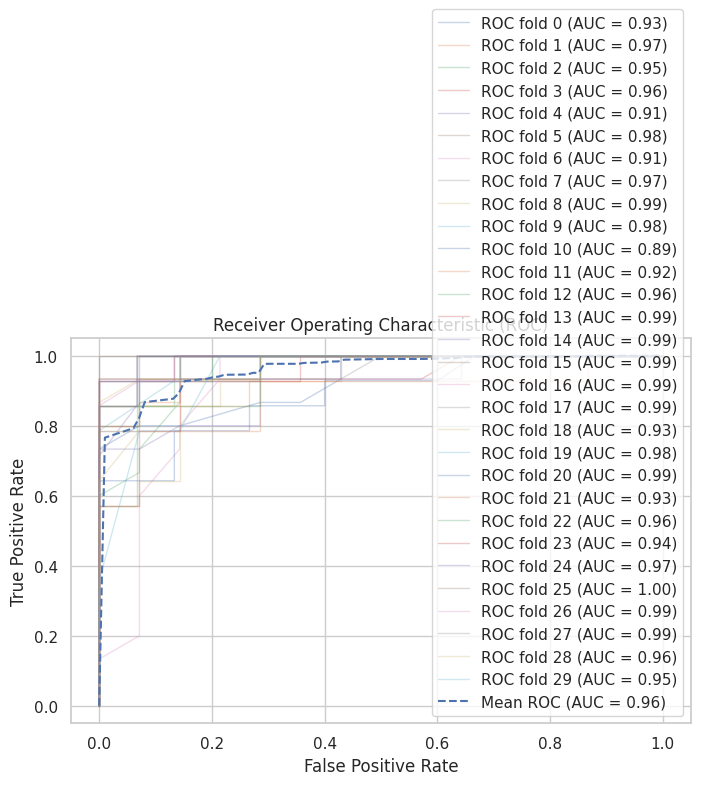

Accuracy (Avg. +/- Std.) is 0.875 +/- 0.062
Sensitivity (Avg. +/- Std.) is 0.944 +/- 0.059
Specificity (Avg. +/- Std.) is 0.806 +/- 0.108
Precision (Avg. +/- Std.) is 0.837 +/- 0.079
FOR (Avg. +/- Std.) is 0.062 +/- 0.063
DOR (Avg. +/- Std.) is inf +/- nan


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_adaboost = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    adaboost = AdaBoostClassifier(n_estimators=50, learning_rate=0.1, random_state=69)
    adaboost.fit(X_Train, Y_Train)

    y_pred_proba = adaboost.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_adaboost.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "ADA BOOSTING",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

XGBoost

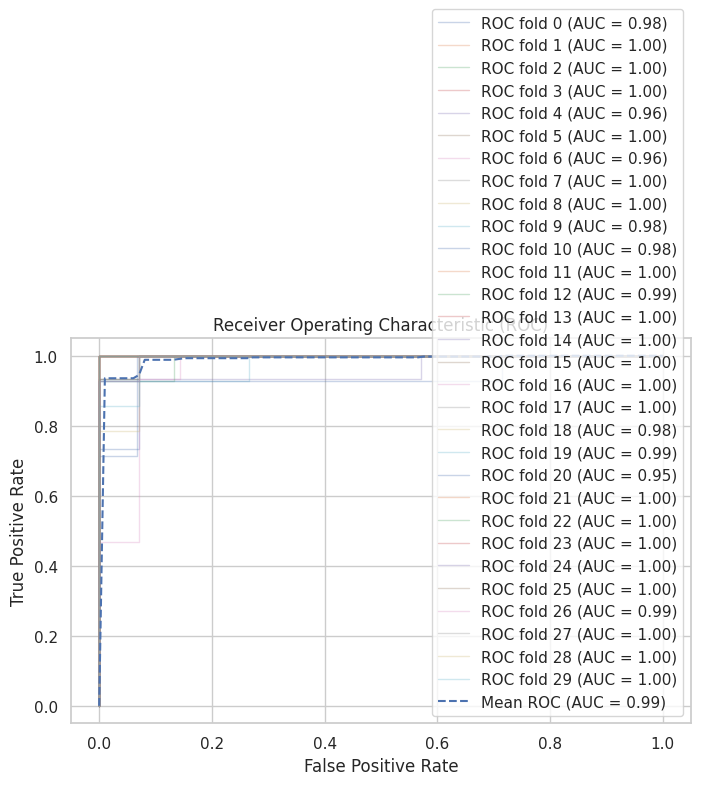

Accuracy (Avg. +/- Std.) is 0.957 +/- 0.033
Sensitivity (Avg. +/- Std.) is 0.979 +/- 0.037
Specificity (Avg. +/- Std.) is 0.935 +/- 0.057
Precision (Avg. +/- Std.) is 0.940 +/- 0.050
FOR (Avg. +/- Std.) is 0.020 +/- 0.036
DOR (Avg. +/- Std.) is inf +/- nan


In [ ]:
import xgboost as xgb

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_xgboost = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    xgboost = xgb.XGBClassifier(n_estimators=15000, learning_rate=0.09, max_depth=3, random_state=69)
    xgboost.fit(X_Train, Y_Train)

    y_pred_proba = xgboost.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_xgboost.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "XG BOOSING",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})


CATEGORICAL BOOSTING

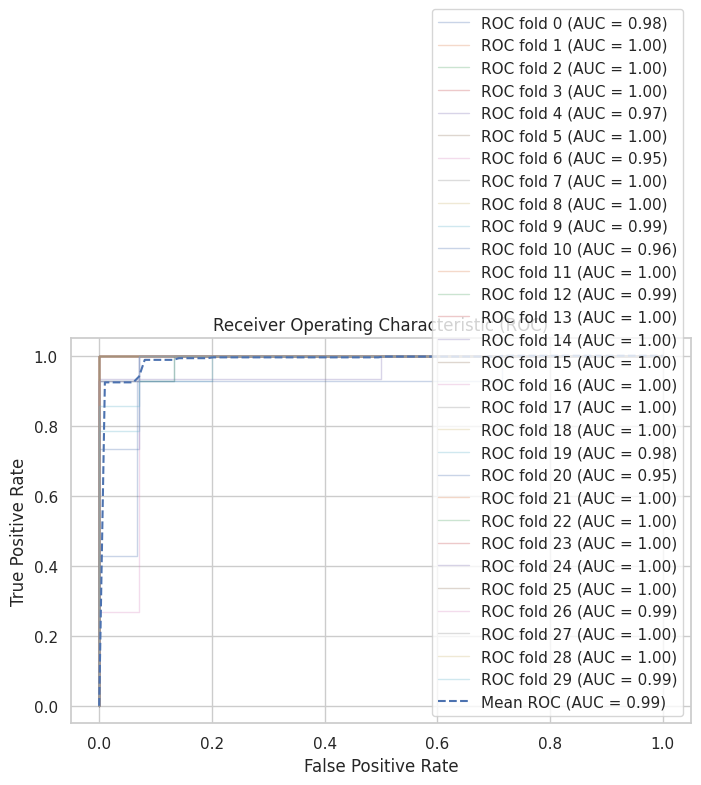

Accuracy (Avg. +/- Std.) is 0.963 +/- 0.037
Sensitivity (Avg. +/- Std.) is 0.983 +/- 0.030
Specificity (Avg. +/- Std.) is 0.942 +/- 0.069
Precision (Avg. +/- Std.) is 0.948 +/- 0.059
FOR (Avg. +/- Std.) is 0.016 +/- 0.029
DOR (Avg. +/- Std.) is inf +/- nan


In [ ]:
from catboost import CatBoostClassifier
n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_catboost = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    catboost_params = {
        'iterations': 900,
        'learning_rate': 0.05,
        'depth': 5,
        'l2_leaf_reg': 3,
        'loss_function': 'Logloss',
        'verbose': 0,
        'random_seed': 69
    }

    clf = CatBoostClassifier(**catboost_params)
    clf.fit(X_Train, Y_Train)

    y_pred_proba = clf.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_catboost.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)


plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "CATEGORICAL BOOSTING",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

ENSEMBLING


XG AND CATEGORICAL BOOSTING

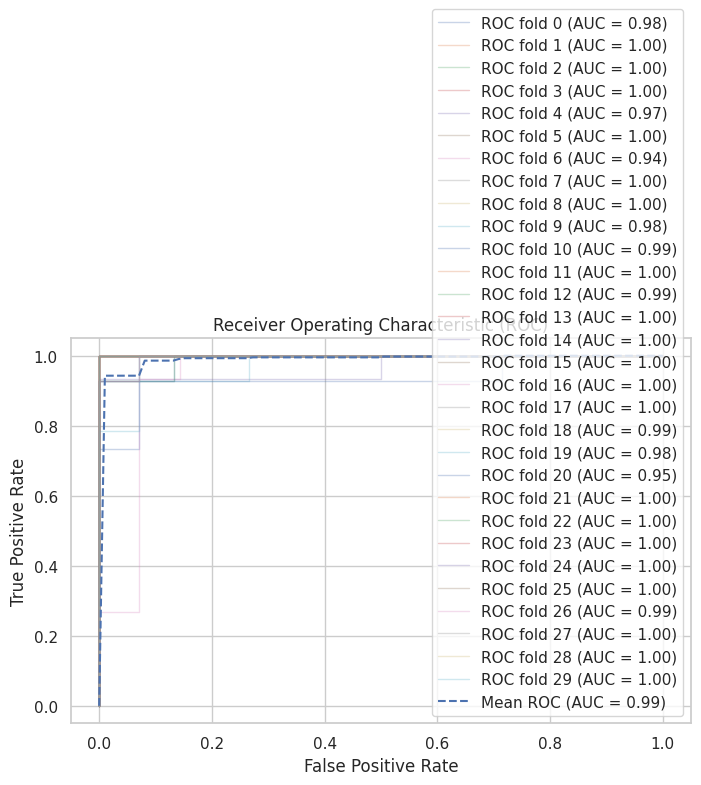

Accuracy (Avg. +/- Std.) is 0.964 +/- 0.033
Sensitivity (Avg. +/- Std.) is 0.979 +/- 0.037
Specificity (Avg. +/- Std.) is 0.949 +/- 0.054
Precision (Avg. +/- Std.) is 0.953 +/- 0.047
FOR (Avg. +/- Std.) is 0.020 +/- 0.035
DOR (Avg. +/- Std.) is inf +/- nan


In [ ]:
from sklearn.ensemble import VotingClassifier

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_ensemble = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    catboost = CatBoostClassifier(iterations=900, learning_rate=0.05, depth=5, l2_leaf_reg=3, loss_function='Logloss', verbose=0, random_seed=69)
    catboost.fit(X_Train, Y_Train)

    xgboost = xgb.XGBClassifier(n_estimators=20000, learning_rate=0.09, max_depth=3, random_state=69)
    xgboost.fit(X_Train, Y_Train)

    ensemble = VotingClassifier(estimators=[
        ('catboost', catboost),
        ('xgboost', xgboost)
    ], voting='soft')

    ensemble.fit(X_Train, Y_Train)

    ensemble_proba = ensemble.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(Y_Test, (ensemble_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, ensemble_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_ensemble.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    accuracy = accuracy_score(Y_Test, (ensemble_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))


results.append({
        "Model Algorithm Name": "XG AND CATEGORICAL BOOSTING",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

XG BOOSTING AND RANDOM FOREST

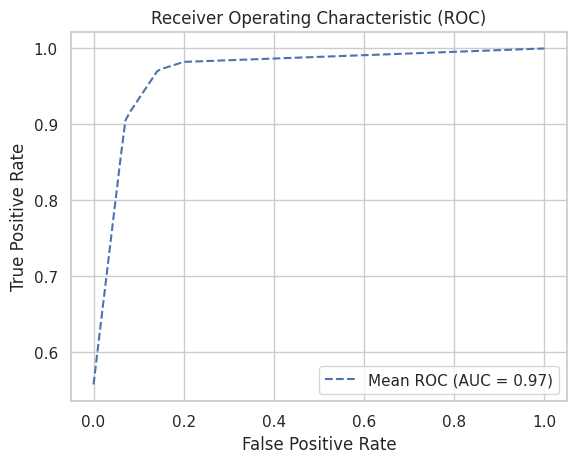

Accuracy (Avg. +/- Std.) is 0.969 +/- 0.033
Sensitivity (Avg. +/- Std.) is 0.979 +/- 0.037
Specificity (Avg. +/- Std.) is 0.958 +/- 0.056
Precision (Avg. +/- Std.) is 0.962 +/- 0.049
FOR (Avg. +/- Std.) is 0.020 +/- 0.035
DOR (Avg. +/- Std.) is inf +/- nan


In [ ]:
from xgboost import XGBClassifier
n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    xgboost = XGBClassifier(n_estimators=20000, learning_rate=0.09, max_depth=3, random_state=69)
    xgboost.fit(X_Train, Y_Train)


    rf = RandomForestClassifier(n_estimators=100, random_state=69)
    rf.fit(X_Train, Y_Train)

    ensemble = VotingClassifier(estimators=[('xgboost', xgboost), ('rf', rf)], voting='hard')
    ensemble.fit(X_Train, Y_Train)
    y_pred_ensemble = ensemble.predict(X_Test)


    accuracy = accuracy_score(Y_Test, y_pred_ensemble)
    Accuracy.append(accuracy)


    tn, fp, fn, tp = confusion_matrix(Y_Test, y_pred_ensemble).ravel()
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)


    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    for_ = fn / (fn + tn)
    dor = (tp / fn) / (fp / tn)

    sn.append(sensitivity)
    sp.append(specificity)
    pr.append(precision)
    FOR.append(for_)
    DOR.append(dor)

    fpr, tpr, thresholds = roc_curve(Y_Test, y_pred_ensemble)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
    "Model Algorithm Name": "XG AND RANDOM FOREST",
    "Accuracy": np.mean(Accuracy),
    "Sensitivity": np.mean(sn),
    "Specificity": np.mean(sp),
    "Precision": np.mean(pr),
    "FOR": np.mean(FOR),
    "DOR": np.mean(DOR),
})

XG BOOST AND K NEAREST NEIGHBOR

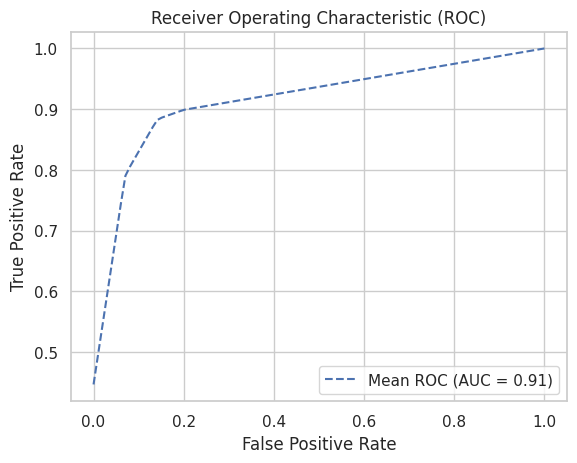

Accuracy (Avg. +/- Std.) is 0.915 +/- 0.057
Sensitivity (Avg. +/- Std.) is 0.881 +/- 0.095
Specificity (Avg. +/- Std.) is 0.949 +/- 0.059
Precision (Avg. +/- Std.) is 0.948 +/- 0.059
FOR (Avg. +/- Std.) is 0.105 +/- 0.077
DOR (Avg. +/- Std.) is inf +/- nan


In [ ]:
n_splits = 30
Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    xgboost = XGBClassifier(n_estimators=20000, learning_rate=0.09, max_depth=3, random_state=69)
    xgboost.fit(X_Train, Y_Train)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_Train, Y_Train)

    ensemble = VotingClassifier(estimators=[('xgboost', xgboost), ('knn', knn)], voting='hard')
    ensemble.fit(X_Train, Y_Train)
    y_pred_ensemble = ensemble.predict(X_Test)


    accuracy = accuracy_score(Y_Test, y_pred_ensemble)
    Accuracy.append(accuracy)


    tn, fp, fn, tp = confusion_matrix(Y_Test, y_pred_ensemble).ravel()
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)


    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    for_ = fn / (fn + tn)
    dor = (tp / fn) / (fp / tn)

    sn.append(sensitivity)
    sp.append(specificity)
    pr.append(precision)
    FOR.append(for_)
    DOR.append(dor)

    fpr, tpr, thresholds = roc_curve(Y_Test, y_pred_ensemble)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    iterator += 1


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "XG BOOSTING AND K NEAREST NEIGHBOR",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

CATEGORICAL BOOSTING AND K NEAREST NEIGHBOR

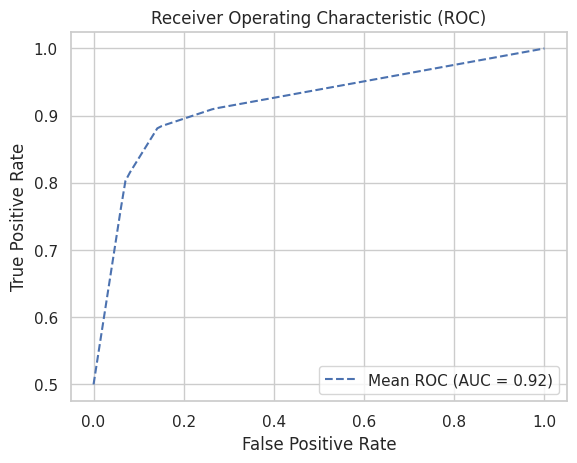

Accuracy (Avg. +/- Std.) is 0.919 +/- 0.055
Sensitivity (Avg. +/- Std.) is 0.883 +/- 0.094
Specificity (Avg. +/- Std.) is 0.953 +/- 0.065
Precision (Avg. +/- Std.) is 0.954 +/- 0.062
FOR (Avg. +/- Std.) is 0.102 +/- 0.074
DOR (Avg. +/- Std.) is inf +/- nan


In [ ]:
n_splits = 30
Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]


    catboost = CatBoostClassifier(iterations=900, learning_rate=0.05, depth=5, l2_leaf_reg=3, loss_function='Logloss', verbose=0, random_seed=69)
    catboost.fit(X_Train, Y_Train)


    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_Train, Y_Train)


    ensemble = VotingClassifier(estimators=[('catboost', catboost), ('knn', knn)], voting='hard')
    ensemble.fit(X_Train, Y_Train)
    y_pred_ensemble = ensemble.predict(X_Test)


    accuracy = accuracy_score(Y_Test, y_pred_ensemble)
    Accuracy.append(accuracy)


    tn, fp, fn, tp = confusion_matrix(Y_Test, y_pred_ensemble).ravel()
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)


    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    for_ = fn / (fn + tn)
    dor = (tp / fn) / (fp / tn)

    sn.append(sensitivity)
    sp.append(specificity)
    pr.append(precision)
    FOR.append(for_)
    DOR.append(dor)

    fpr, tpr, thresholds = roc_curve(Y_Test, y_pred_ensemble)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr = np.array(mean_tpr)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "CATEGORICAL BOOSTING AND K NEAREST NEIGHBOR",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

CATEGORICAL BOOSTING AND RANDOM FOREST

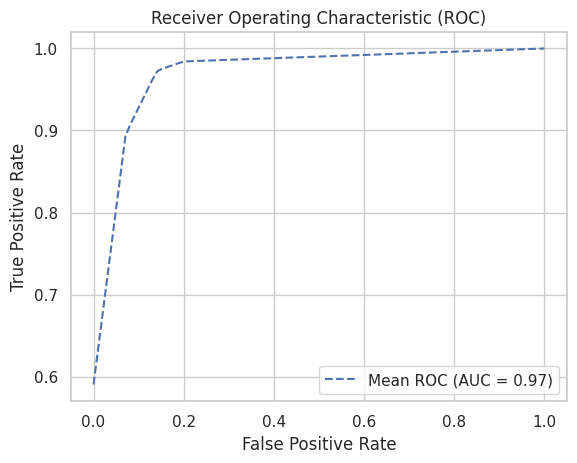

Accuracy (Avg. +/- Std.) is 0.970 +/- 0.033
Sensitivity (Avg. +/- Std.) is 0.981 +/- 0.031
Specificity (Avg. +/- Std.) is 0.958 +/- 0.058
Precision (Avg. +/- Std.) is 0.962 +/- 0.052
FOR (Avg. +/- Std.) is 0.018 +/- 0.030
DOR (Avg. +/- Std.) is inf +/- nan


In [ ]:
n_splits = 30
Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)

kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]


    catboost = CatBoostClassifier(iterations=1500, learning_rate=0.05, depth=5, l2_leaf_reg=3, loss_function='Logloss', verbose=0, random_seed=69)
    catboost.fit(X_Train, Y_Train)


    rf = RandomForestClassifier(n_estimators=500, random_state=69)
    rf.fit(X_Train, Y_Train)


    ensemble = VotingClassifier(estimators=[('catboost', catboost), ('rf', rf)], voting='hard')
    ensemble.fit(X_Train, Y_Train)
    y_pred_ensemble = ensemble.predict(X_Test)


    accuracy = accuracy_score(Y_Test, y_pred_ensemble)
    Accuracy.append(accuracy)


    tn, fp, fn, tp = confusion_matrix(Y_Test, y_pred_ensemble).ravel()
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)


    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    for_ = fn / (fn + tn)
    dor = (tp/fn) / (fp/tn)

    sn.append(sensitivity)
    sp.append(specificity)
    pr.append(precision)
    FOR.append(for_)
    DOR.append(dor)

    fpr, tpr, thresholds = roc_curve(Y_Test, y_pred_ensemble)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    iterator += 1


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "CATEGORICAL BOOSTING AND RANDOM FOREST",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

In [ ]:
import json

pretty_printed = json.dumps(results, indent=2)
print(pretty_printed)

CatBooost + RF Model for females


In [ ]:
from sklearn.preprocessing import StandardScaler
sc_female = StandardScaler()

In [ ]:
X_Data = data.drop('Outcome',axis=1).values
Y_Lavel = data.iloc[:,-1].values

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=69)
X_Data, Y_Lavel = ros.fit_resample(X_Data, Y_Lavel)


In [ ]:
X_Data=sc_female.fit_transform(X_Data)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_Data,Y_Lavel,test_size=0.3,random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
catboost = CatBoostClassifier(iterations=1500, learning_rate=0.05, depth=5, l2_leaf_reg=3, loss_function='Logloss', verbose=0, random_seed=69)
catboost.fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=500, random_state=69)
rf.fit(X_train, y_train)
ensemble = VotingClassifier(estimators=[('catboost', catboost), ('rf', rf)], voting='soft')
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7b657ed63850>),
                             ('rf',
                              RandomForestClassifier(n_estimators=500,
                                                     random_state=69))],
                 voting='soft')

In [ ]:
import pickle
with open('female_model.sav','wb') as file:
  pickle.dump(ensemble,file)

CatBoost + RF model for males

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_male = StandardScaler()

In [ ]:
X_Data = data.drop(['Pregnancies','Outcome'],axis=1).values
Y_Lavel = data.iloc[:,-1].values

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=69)
X_Data, Y_Lavel = ros.fit_resample(X_Data, Y_Lavel)

In [ ]:
sc_male.fit(X_Data)

StandardScaler()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
catboost = CatBoostClassifier(iterations=1500, learning_rate=0.05, depth=5, l2_leaf_reg=3, loss_function='Logloss', verbose=0, random_seed=69)
catboost.fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=500, random_state=69)
rf.fit(X_train, y_train)
ensemble = VotingClassifier(estimators=[('catboost', catboost), ('rf', rf)], voting='soft')
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7b657e9028c0>),
                             ('rf',
                              RandomForestClassifier(n_estimators=500,
                                                     random_state=69))],
                 voting='soft')

In [ ]:
import pickle
with open('male_model.sav','wb') as file:
  pickle.dump(ensemble,file)